# Debug Qiskit Runtime jobs

Before submitting a resource-intensive Qiskit Runtime workload to execute on hardware, you can verify that your workload is set up correctly and is likely to give the experimental results you expect with the Qiskit Runtime [`Neat` (Noisy Estimator Analyzer Tool)](/api/qiskit-ibm-runtime/qiskit_ibm_runtime.debug_tools.Neat#neat) class. 

`Neat` uses `qiskit-aer` to classically simulate an estimation task efficiently in both ideal ([`ideal_sim`](/api/qiskit-ibm-runtime/qiskit_ibm_runtime.debug_tools.Neat#ideal_sim)) and noisy ([`noisy_sim`](/api/qiskit-ibm-runtime/qiskit_ibm_runtime.debug_tools.Neat#noisy_sim)) conditions, so that you can compare the simulation results to draw custom figures of merit. Its [`to_clifford` method](/api/qiskit-ibm-runtime/qiskit_ibm_runtime.debug_tools.Neat#to_clifford) Cliffordizes primitive unified blocs (PUBs) to render them easily simulable.

The following example demonstrates how to use the `Neat` class to choose the best noise factor before running the workload on a QPU.

## Set up the experiment

First, import the relevant packages.

In [1]:
import numpy as np

from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp

from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit_ibm_runtime.debug_tools import Neat
from qiskit_ibm_runtime.noise_learner import NoiseLearner

from qiskit_aer.noise import NoiseModel, depolarizing_error

In [2]:
# Choose the least busy backend
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)

In [3]:
noise_model = None  # You could specify a custom `NoiseModel` here

# Initialize a neat object
analyzer = Neat(backend, noise_model)

In [4]:
# Generate a preset pass manager 
pm = generate_preset_pass_manager(backend=backend, optimization_level=0)

In [ ]:
# Set up a tool to create scatter plots

import plotly.graph_objects as go

def scattered_plot(tw_res, noise_res, obs):
    fig = go.Figure(layout=go.Layout(width=700, height=500))

    fig.add_trace(
        go.Scatter(
            x=obs,
            y=tw_res[0].data.evs,
            error_y=dict(array=tw_res[0].data.stds),
            mode="markers",
            name="exp. results (twirling)",
            showlegend=True,
        )
    )

    xs = []
    ys = []
    for r in noise_res:
        xs += obs
        ys += r[0].vals.tolist()
    fig.add_trace(
        go.Scatter(
            x=xs,
            y=ys,
            mode="markers",
            name="debugger",
            showlegend=True,
        )
    )

    fig.update_yaxes(range=[0.7, 1])

    return fig

# Initialize a target circuit

This example uses the Trotterized time evolution of a 2D transverse-field Ising model, which is the same circuit that was used in the paper [Evidence for the utility of quantum computing before fault tolerance.](https://www.nature.com/articles/s41586-023-06096-3)  

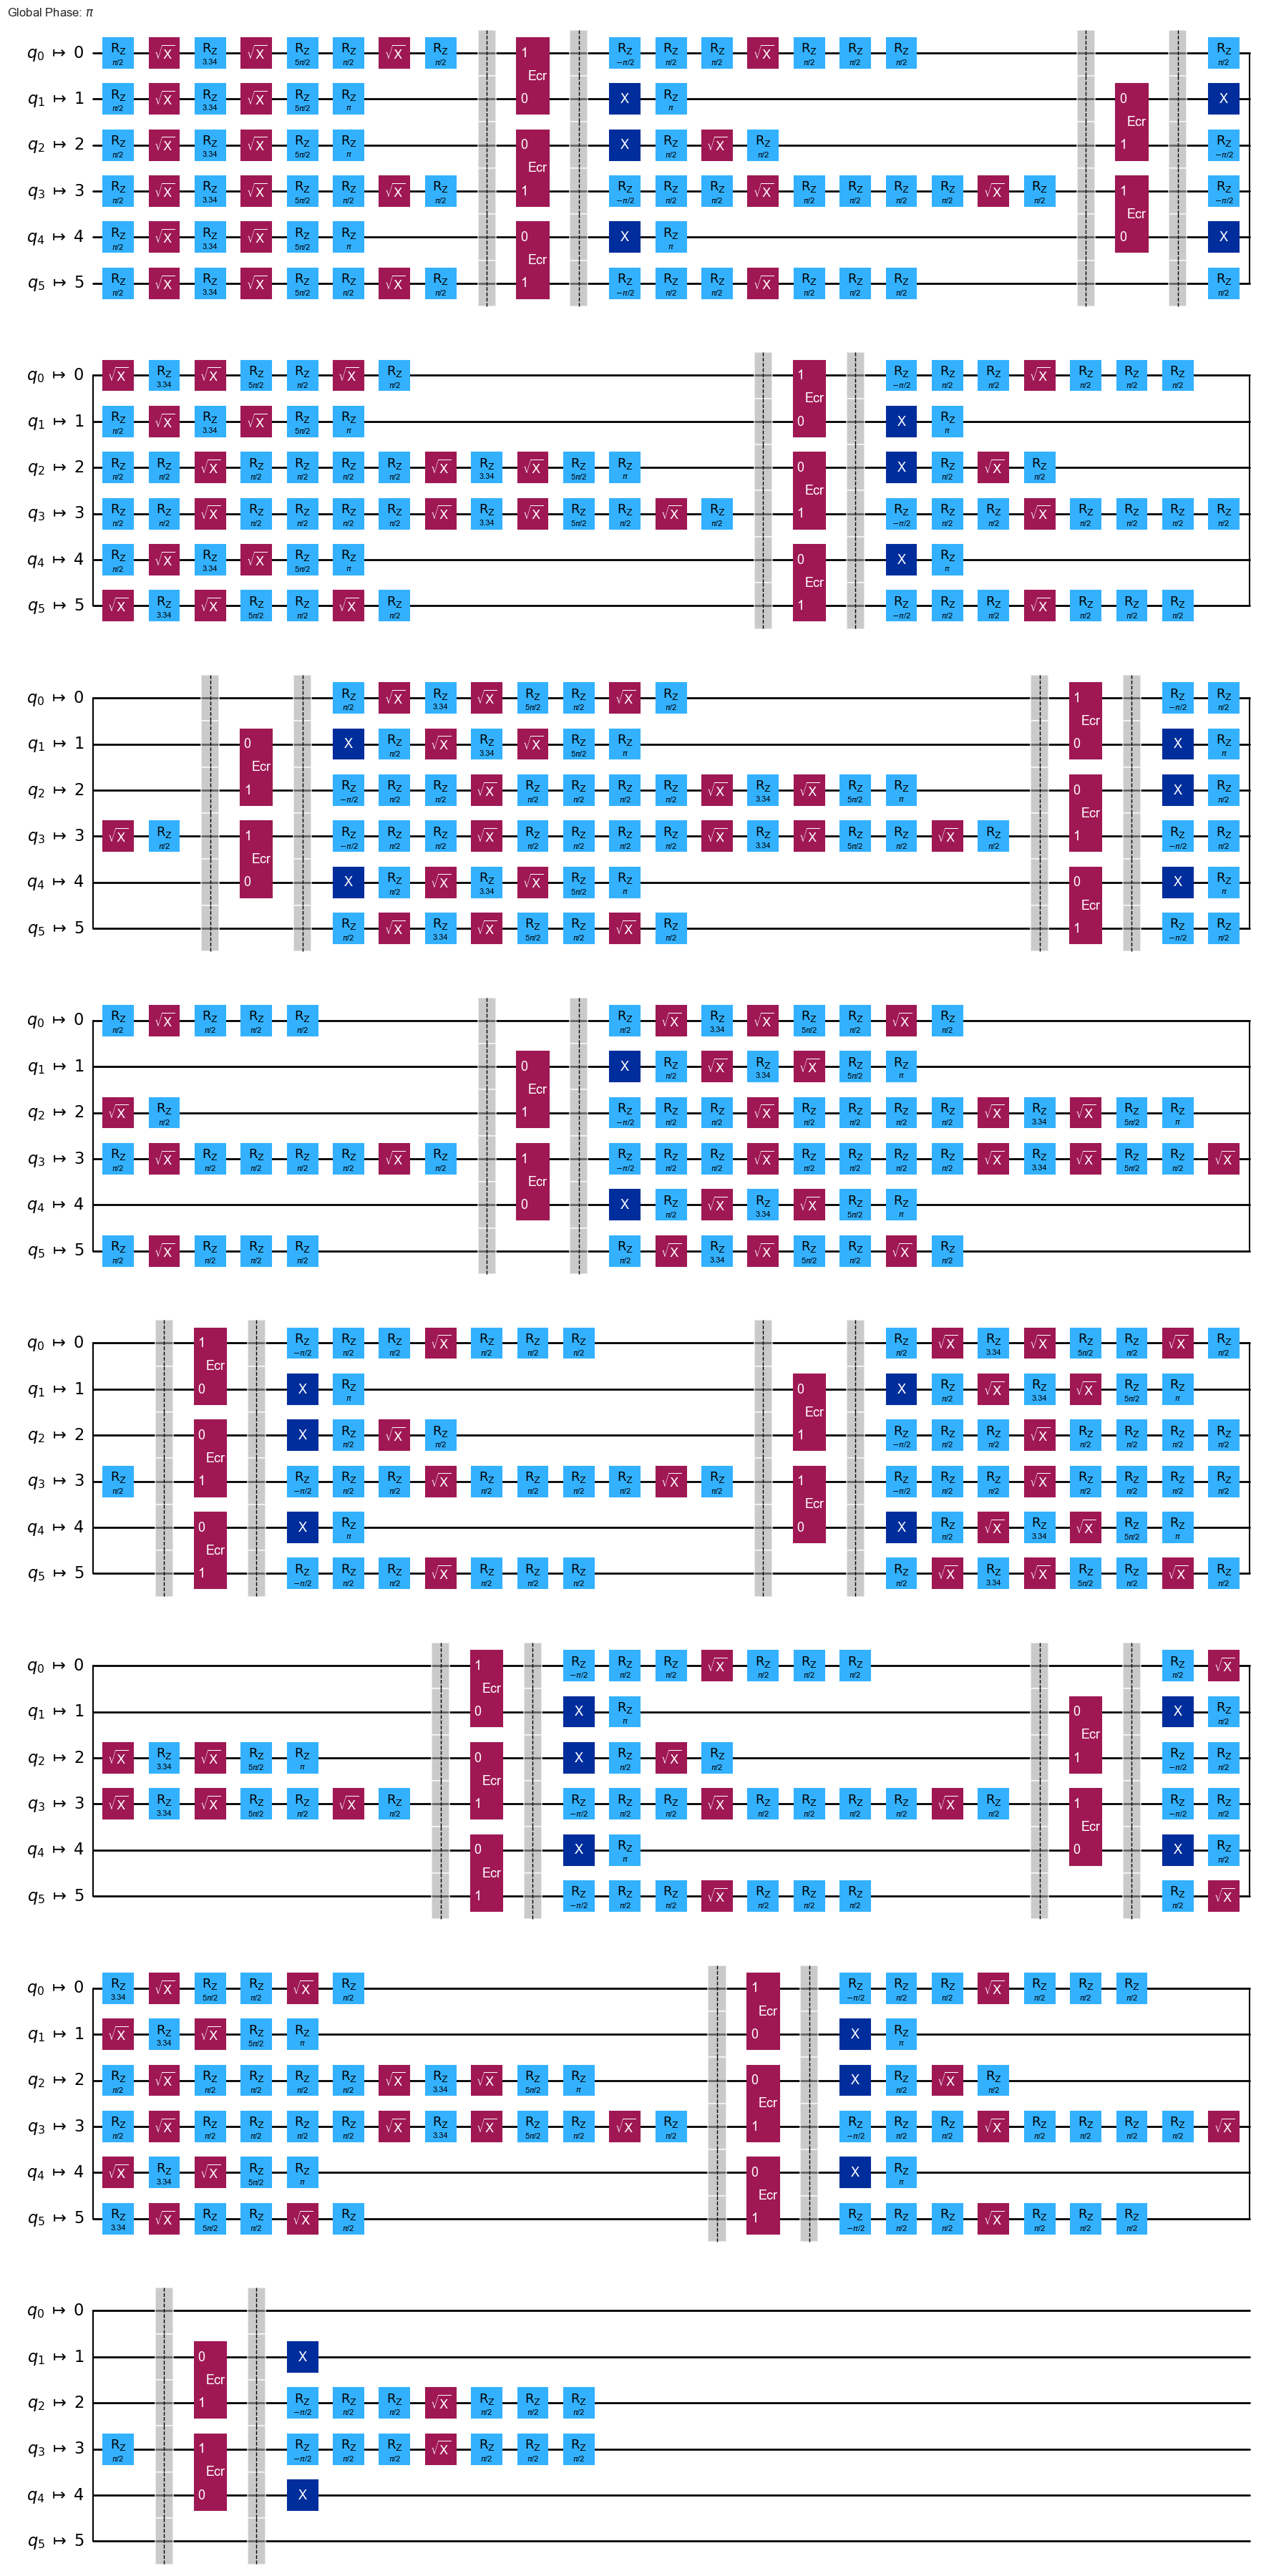

In [7]:
# Generate the circuit with 6 qubits and 12 entangling layers.

layer_couplings = [
    [(1, 0), (2, 3), (4, 5)],
    [(1, 2), (4, 3)],
]

theta = 0.2
num_steps = 2

qc = QuantumCircuit(6)
qc.rz(theta, range(qc.num_qubits))
for step in range(num_steps):
    qc.barrier()
    for q0, q1 in layer_couplings[0]:
        qc.ecr(q0, q1)
    qc.barrier()
    for q0, q1 in layer_couplings[1]:
        qc.ecr(q0, q1)

isa_qc = pm.run(qc)
isa_qc.draw("mpl", idle_wires=0)

We choose single `Z` as observables for our PUB.

In [8]:
num_qubits = qc.num_qubits

obs = ["I" * q + "Z" + "I" * (num_qubits - q - 1) for q in range(num_qubits)]
print(f"Observables: {obs}")
    
isa_obs = [SparsePauliOp(o).apply_layout(isa_qc.layout) for o in obs]
pubs = [(isa_qc, isa_obs)]

Observables: ['ZIIIII', 'IZIIII', 'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ']


## Cliffordizing the target circuit

To Cliffordize the `pubs` we use the debugger's `to_clifford` method, which is a wrapper around a new `ConvertISAToClifford` transpiler pass.

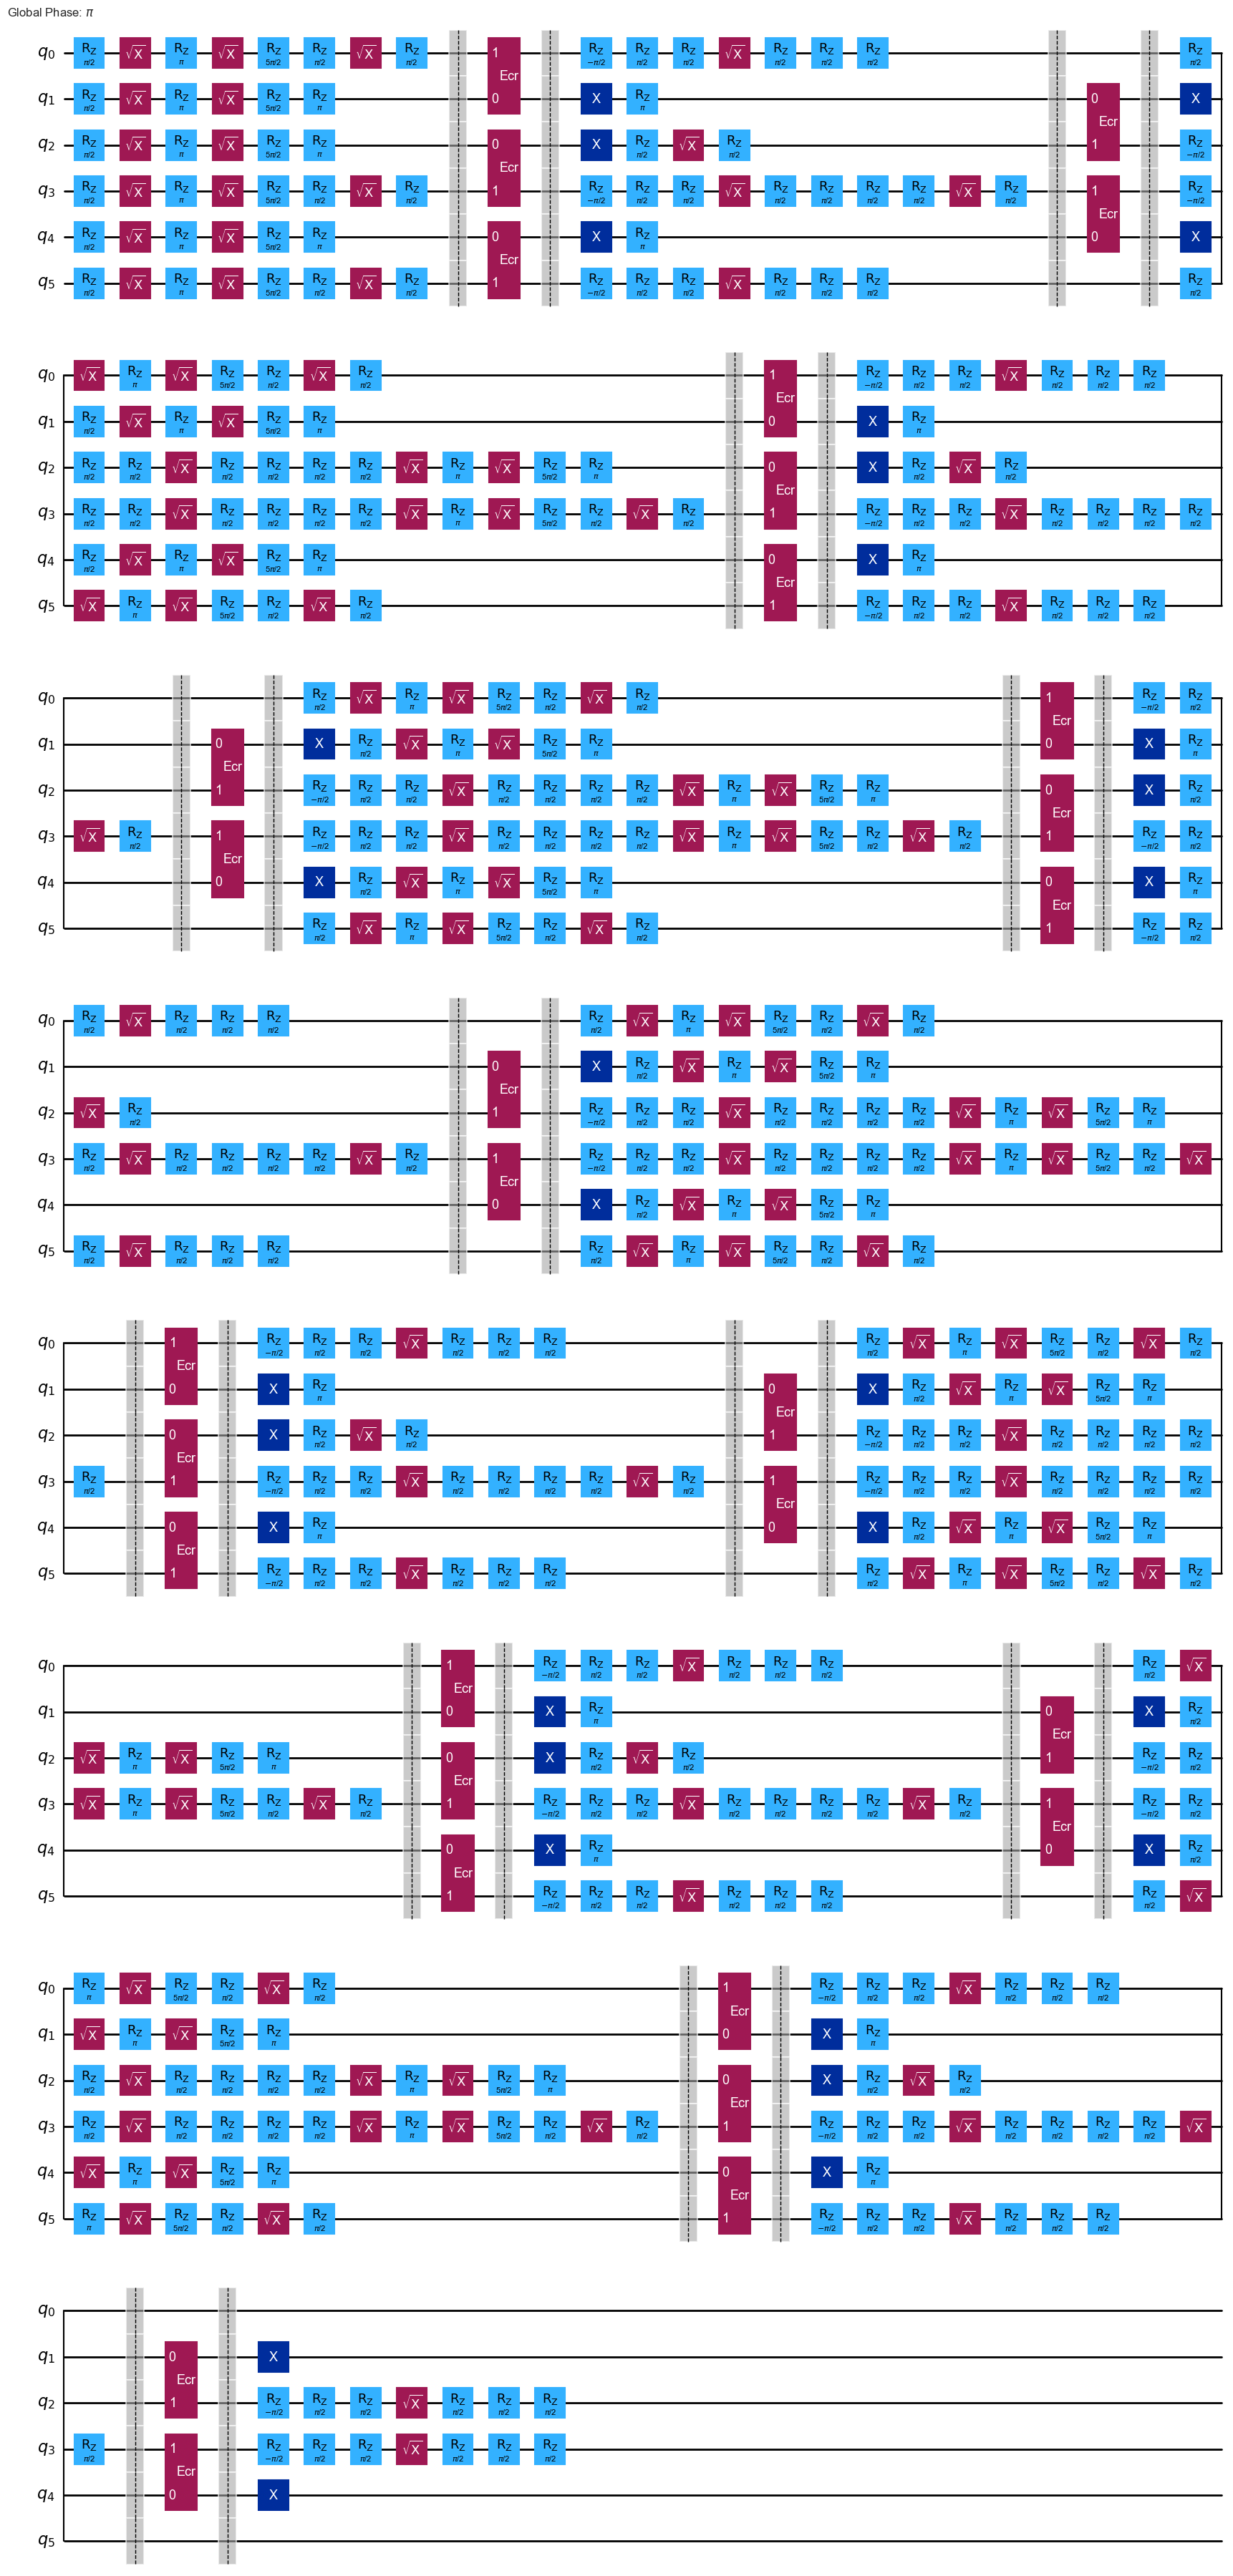

In [9]:
clifford_pubs = analyzer.to_clifford(pubs)

clifford_pubs[0].circuit.draw("mpl", idle_wires=0)

## Application I. Benchmarking different strategies

### Example 2.
PEA requires to specify a set of noise amplification factors.<br> 
What choice of noise amplification factors is best for my problem?

In [6]:
noise_factors = [
    [1, 1.1],
    [1, 1.1, 1.2],
    [1, 1.5, 2],
    [1, 1.5, 2, 2.5, 3],
    [1, 4],
]

jobs = []
for factors in noise_factors:
    estimator.options.resilience.zne.noise_factors = factors
    jobs.append(estimator.run(clifford_pubs))

res0 = jobs[0].result()
res1 = jobs[1].result()
res2 = jobs[2].result()
res3 = jobs[3].result()
res4 = jobs[4].result()

In [17]:
results = [res0, res1, res2, res3, res4]

for factors, res in zip(noise_factors, results):
    d = rdiff(ideal_res, res)
    print(f"Mean rel. diff. for factors {factors}:\n  {np.round(np.mean(d), 2)}%\n")

Mean rel. diff. for factors [1, 1.1]:
  8.08%

Mean rel. diff. for factors [1, 1.1, 1.2]:
  4.42%

Mean rel. diff. for factors [1, 1.5, 2]:
  1.9%

Mean rel. diff. for factors [1, 1.5, 2, 2.5, 3]:
  2.08%

Mean rel. diff. for factors [1, 4]:
  1.39%



## [WIP] Application II. Using the analyzer to benchmark different noise models

Goal:
<br>Using NEAT to identify a noise model that fits my data, in order to:

- Learn is my noise model is accurate.
- Be able to make predictions.
- [FUTURE] Did I set the parameters of my noise learner correctly?

In [18]:
# Results obtained with twirling and no PEA
job_twirled = service.job("cwgm20r0r6b0008pgtm0")
tw_res = job_twirled.result()

In [19]:
# Do the results of a noisy sim fit the observed data?

analyzer.noisy_sim(clifford_pubs)

NeatResult([NeatPubResult(vals=array([0.82617188, 0.66992188, 0.76367188, 0.7890625 , 0.82421875,
       0.91992188]))])

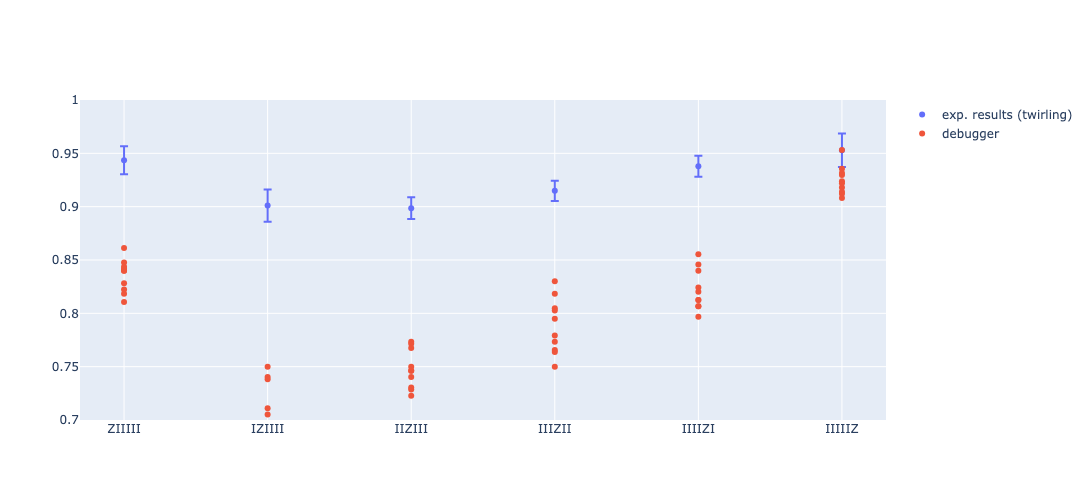

In [20]:
# noise model from backend
noise_res = [analyzer.noisy_sim(clifford_pubs) for _ in range(10)]

scattered_plot(tw_res, noise_res, obs)

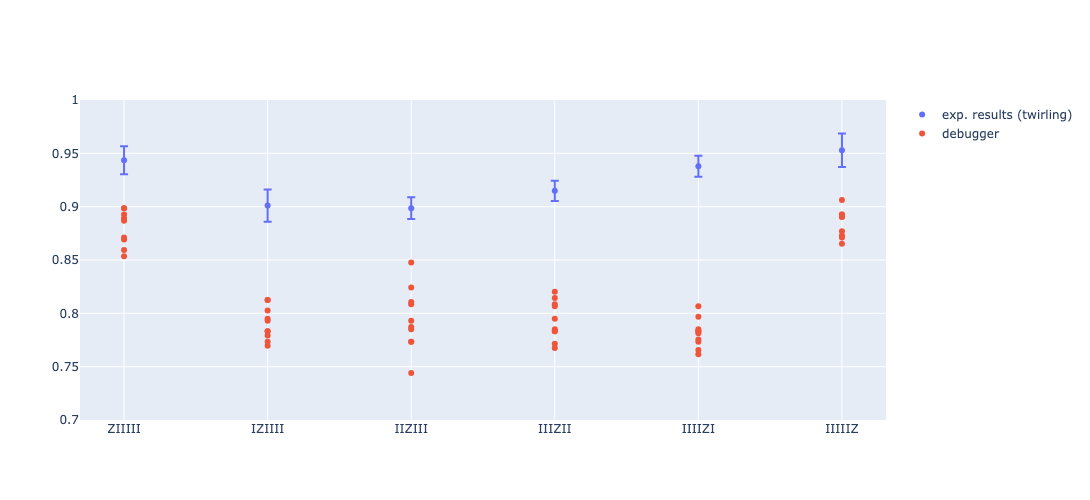

In [21]:
# noise model with dep. noise on every ECR
# - strength: 0.02
# - num_qubits = 2

noise_model = NoiseModel()
for qubits in backend.coupling_map:
    noise_model.add_quantum_error(depolarizing_error(0.02, 2), ["ecr"], qubits)

analyzer.noise_model = noise_model

noise_res = [analyzer.noisy_sim(clifford_pubs) for _ in range(10)]

scattered_plot(tw_res, noise_res, obs)

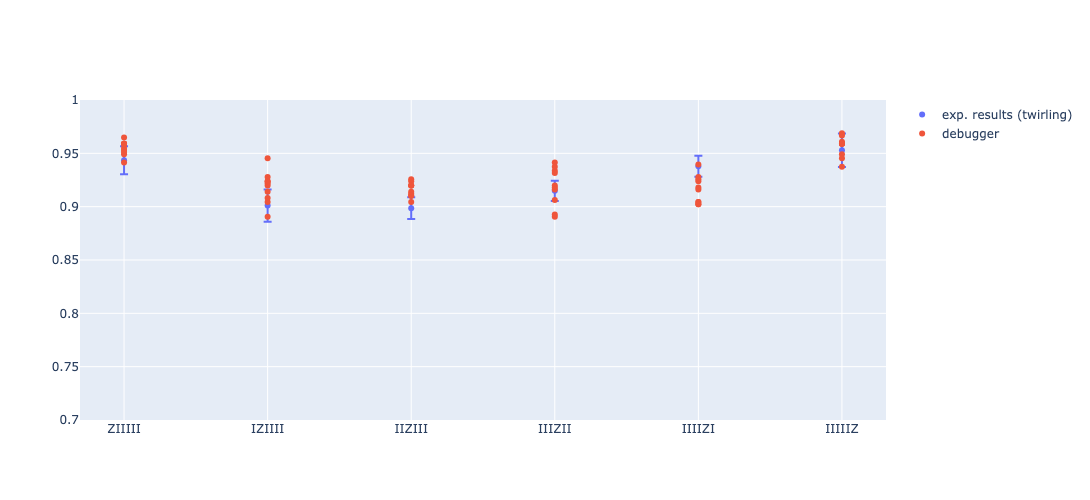

In [22]:
# noise model with dep. noise on every ECR
# - strength: 0.007
# - num_qubits = 2

noise_model = NoiseModel()
for qubits in backend.coupling_map:
    noise_model.add_quantum_error(depolarizing_error(0.007, 2), ["ecr"], qubits)

analyzer.noise_model = noise_model

noise_res = [analyzer.noisy_sim(clifford_pubs) for _ in range(10)]

scattered_plot(tw_res, noise_res, obs)